In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np
import scipy as scp
from statsmodels.tsa.ar_model import AutoReg
from itertools import product
from pylab import rcParams
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Подготовка данных (формирование временного ряда из данных -> создание матрицы)

In [2]:
our_columns = ['icethic_cea', 'iceconc','uice_ipa', 'vice_ipa','snowthic_cea']
df = pd.read_csv('arctic_results/ts_features.csv', header = None)
df.columns = our_columns
times = pd.date_range('2012-01-01', periods=len(df.index), freq='1h')
df.index = times

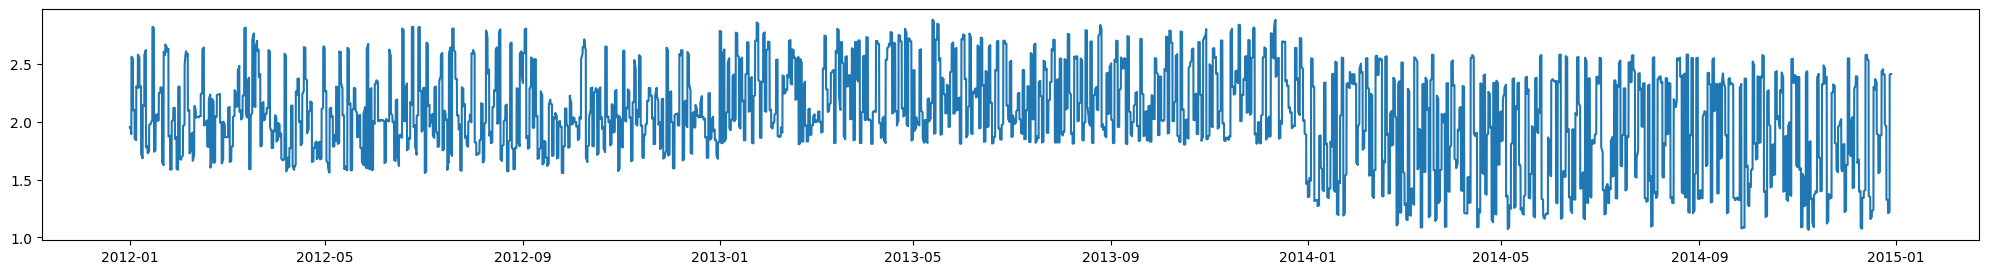

In [3]:
our_data = df['icethic_cea']
plt.subplots(figsize=(25, 3))
plt.plot(our_data)
plt.show()

In [4]:
df['dt'] = df.index
df['dt']=df['dt'].dt.round('1d')
dc = {column: 'mean' for column in our_columns}
df_daily = df.groupby('dt').agg(dc)

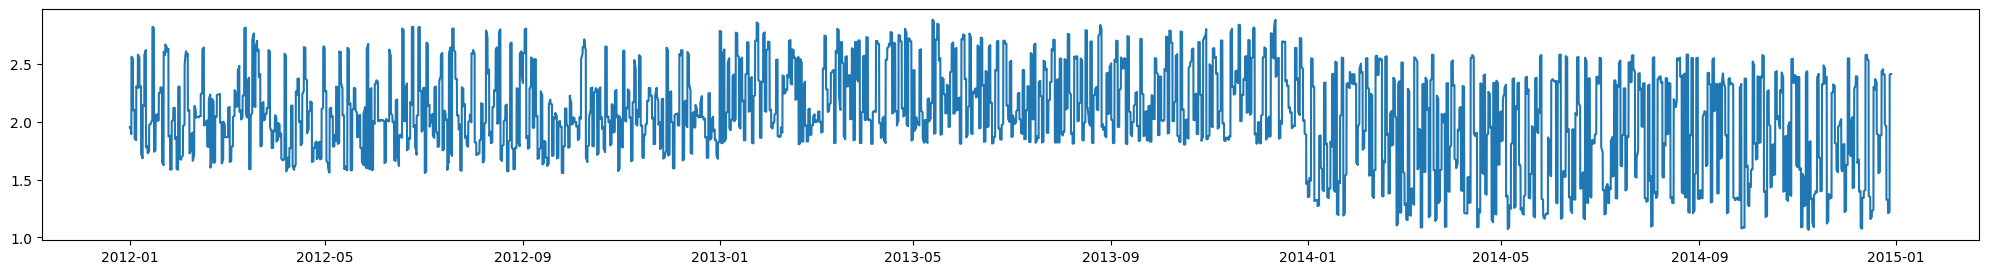

In [5]:
all_data = df_daily['icethic_cea'][:-1]
all_data -= all_data.mean()
plt.subplots(figsize=(25, 3))
plt.plot(our_data)
plt.show()

In [6]:
all_data.shape

(1093,)

# Делим данные на train & test

In [7]:
percent_of_train_data = 60
index_split = all_data.shape[0] // 100 * percent_of_train_data
train_data = all_data[:index_split]
test_data = all_data[index_split:]

print(train_data.shape, test_data.shape)

(600,) (493,)


In [8]:
number_of_data_in_rw = (all_data.shape[0] // 100 * 63) # 63
step = 10 # 10

print(number_of_data_in_rw, step)

630 10


In [9]:
start_idx = 0
mtrx = []
while start_idx + number_of_data_in_rw < all_data.shape[0]:
    mtrx.append(all_data[start_idx:start_idx + number_of_data_in_rw])
    start_idx += step

mtrx = np.array(mtrx)

In [10]:
mtrx.shape

(47, 630)

# SVD

In [11]:
from numpy import linalg

In [12]:
result = linalg.svd(mtrx, full_matrices=False)

In [13]:
result[2].shape

(47, 630)

In [14]:
t = pd.DataFrame(result[2])

In [15]:
criterii = np.median(result[1]) * (4/3)
print(criterii)
comp = result[1][result[1] >= criterii]
print(comp)
print(result[1]) 

8.504758258845452
[21.99060915 18.22888559  9.72591484  9.09259501  8.9466167   8.86626173]
[21.99060915 18.22888559  9.72591484  9.09259501  8.9466167   8.86626173
  8.28506404  8.15703978  7.98974566  7.96861857  7.66609201  7.64140015
  7.59067039  7.45771064  7.40269875  7.35400109  7.0013635   6.97083249
  6.85982614  6.8086924   6.59885197  6.51277033  6.42838892  6.37856869
  6.31941281  6.29992541  6.27795324  6.17837326  6.04167579  5.9168946
  5.86292304  5.80743965  5.67785456  5.59620645  5.43651861  5.40603207
  5.33154295  5.17888991  5.09256039  5.02240648  4.85351875  4.82163463
  4.79394887  4.78067805  4.71520278  4.53752337  4.48997022]


In [16]:
t.head(2)

,0,1,2,3,4,5,6,7,8,9,...,620,621,622,623,624,625,626,627,628,629
0,0.016621,0.026137,0.036656,0.025563,0.009488,0.010219,0.029174,0.021980,0.005717,0.015682,...,-0.041804,-0.038327,-0.015864,-0.017901,-0.068255,-0.087804,-0.077044,-0.060091,-0.053813,-0.050678
1,-0.009054,-0.011391,-0.010399,0.003865,0.021231,0.007605,-0.007824,0.014685,0.030385,0.007303,...,0.028538,0.045972,0.034311,-0.007120,-0.007620,0.015699,0.035650,0.021624,0.006822,0.026106


In [17]:
r = len(comp) + 1

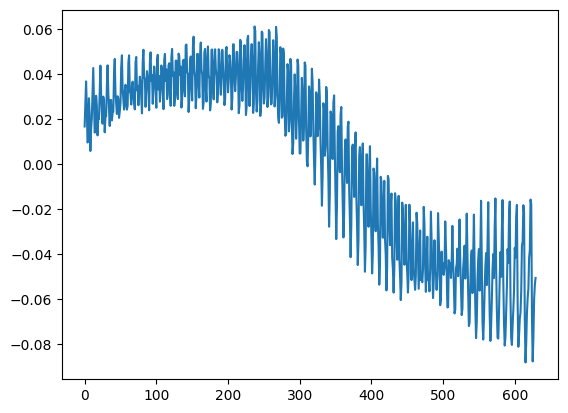

In [18]:
plt.plot(result[2][0, :])
result[2][0, :].shape
plt.show()

In [19]:
V_r = result[2][0:r, :]
print(V_r.shape)

(7, 630)


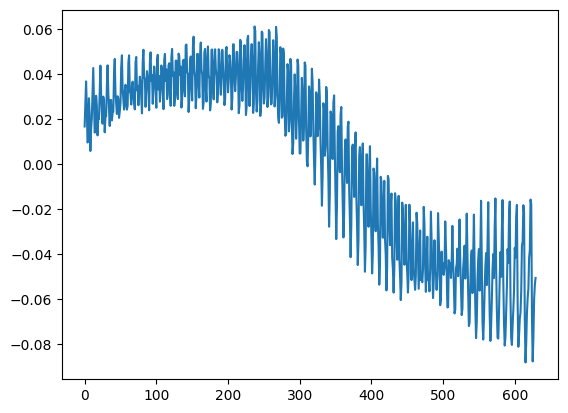

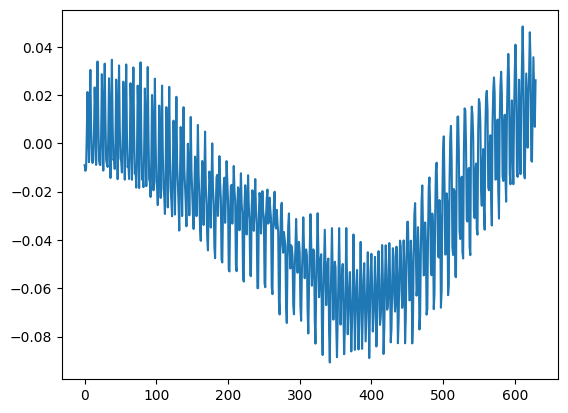

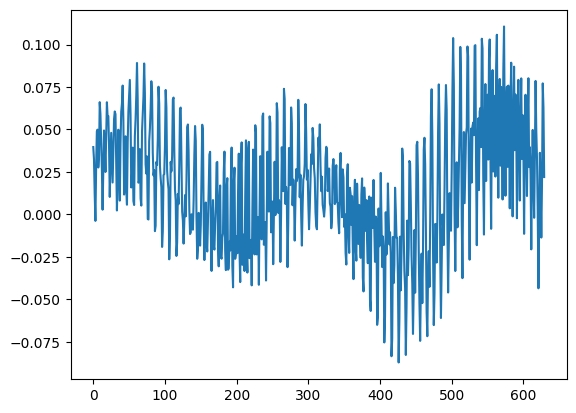

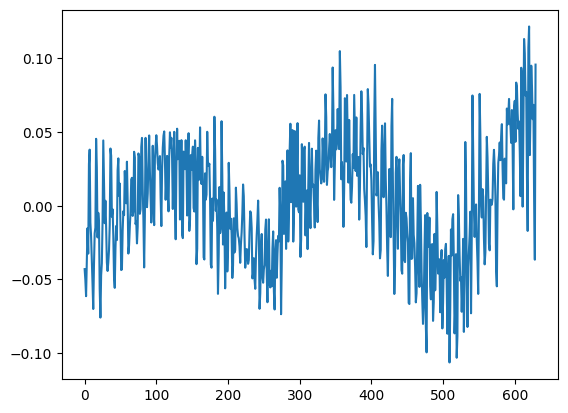

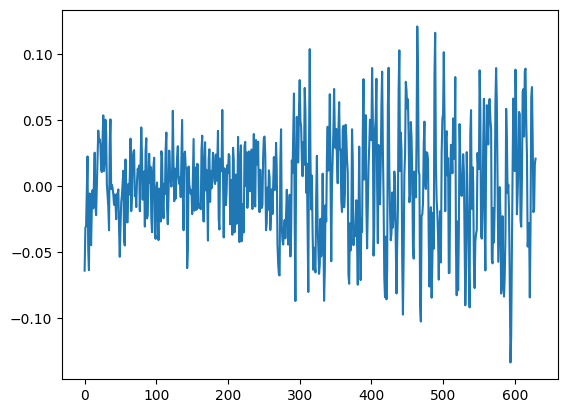

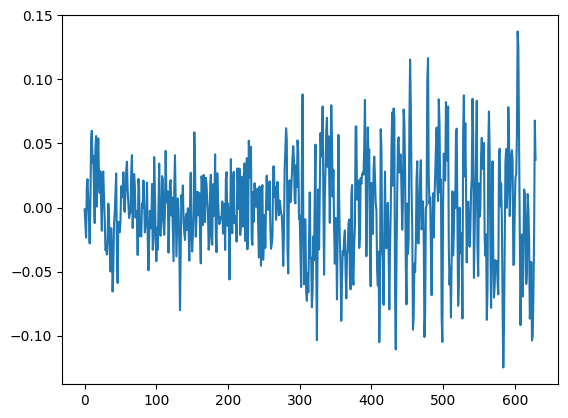

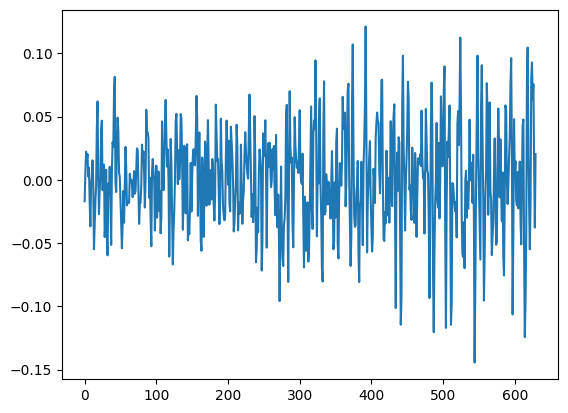

In [20]:
for dinamic in V_r:
    plt.plot(dinamic)
    plt.show()

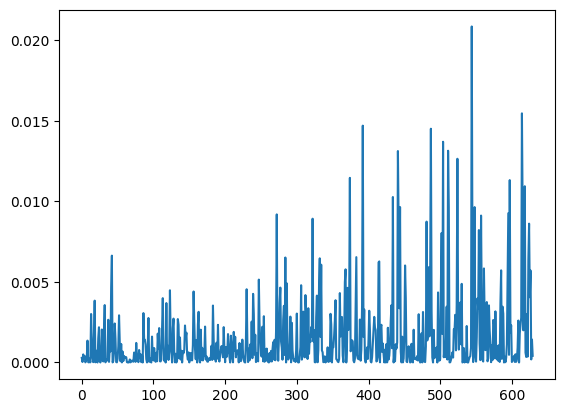

In [21]:
plt.plot(V_r[-1] ** 2)
plt.show()

In [22]:
from scipy.stats import norm
from scipy.stats import poisson

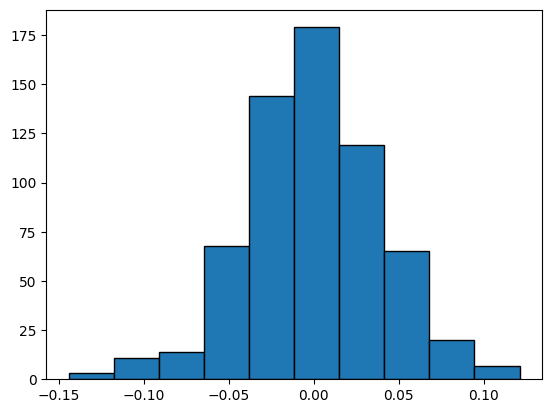

In [23]:
plt.hist(V_r[-1], edgecolor='black')
# plt.plot(np.arange(-0.15, 0.15, 0.01), poisson.ppf(mu=0.01, q=0.1))
plt.show()

In [24]:
print(plt.hist(V_r[-1], edgecolor='black'))

(array([  3.,  11.,  14.,  68., 144., 179., 119.,  65.,  20.,   7.]), array([-0.14440845, -0.11784384, -0.09127923, -0.06471463, -0.03815002,
       -0.01158541,  0.0149792 ,  0.04154381,  0.06810842,  0.09467303,
        0.12123764]), <BarContainer object of 10 artists>)


# TEST DMD for all data

In [25]:
from pydmd import DMD
from pydmd import MrDMD

In [38]:
dmd = DMD(svd_rank=r-3, opt=False, exact=True, tlsq_rank=5)
dmd.fit(V_r[:-1])

In [39]:
A = dmd.atilde

In [40]:
print(A.shape, V_r[:-1].shape)

(4, 4) (6, 630)


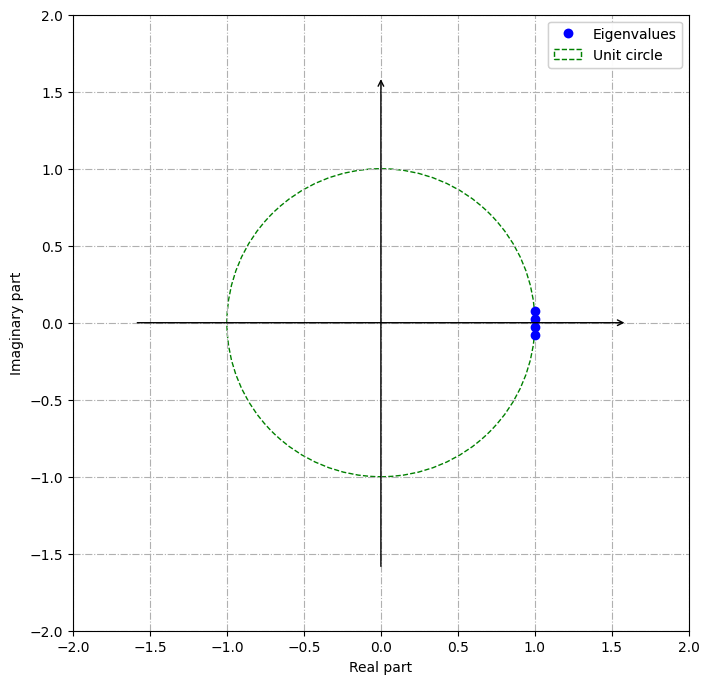

In [41]:
dmd.plot_eigs(show_axes=True, show_unit_circle=True)

In [42]:
percent_of_train_data = 60
index_split = V_r.shape[1] // 100 * percent_of_train_data
train_data = V_r[:, :index_split]
test_data = V_r[:, index_split:]

X_test = np.arange(V_r.shape[1])[index_split:]

print(train_data.shape, test_data.shape)

(7, 360) (7, 270)


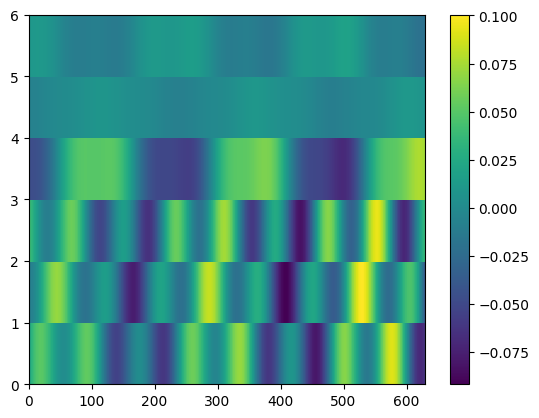

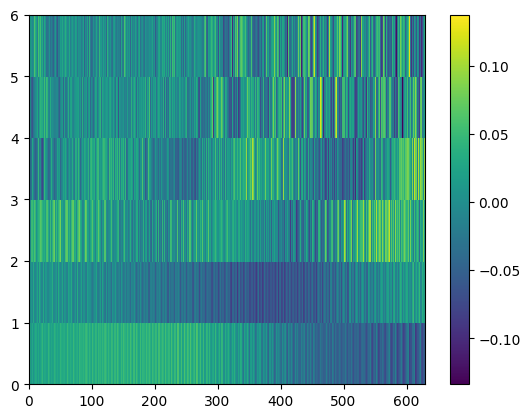

In [43]:
plt.pcolor(np.real(dmd.reconstructed_data))
plt.colorbar()
plt.show()
plt.pcolor(V_r[:-1])
plt.colorbar()

plt.show()

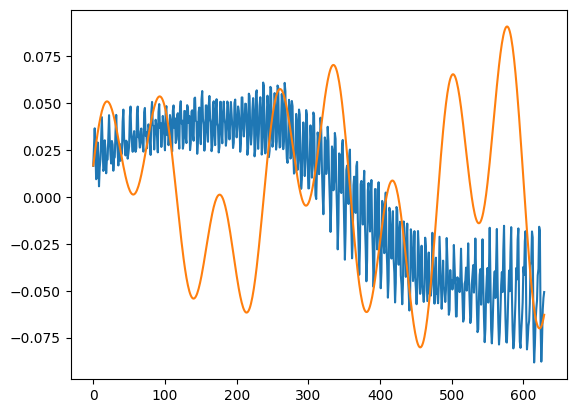

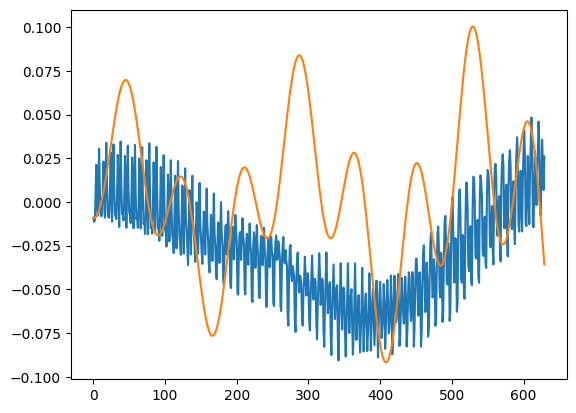

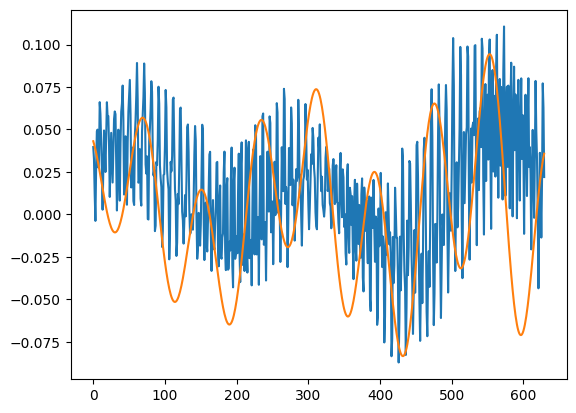

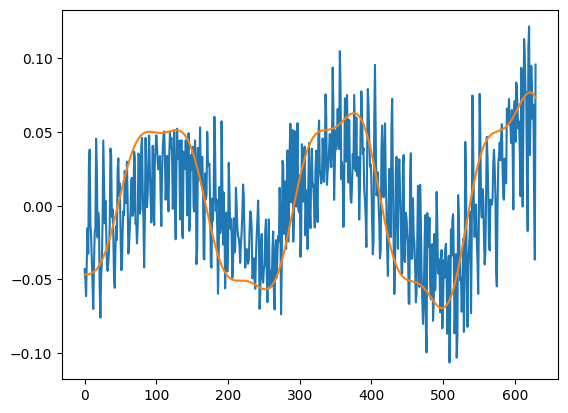

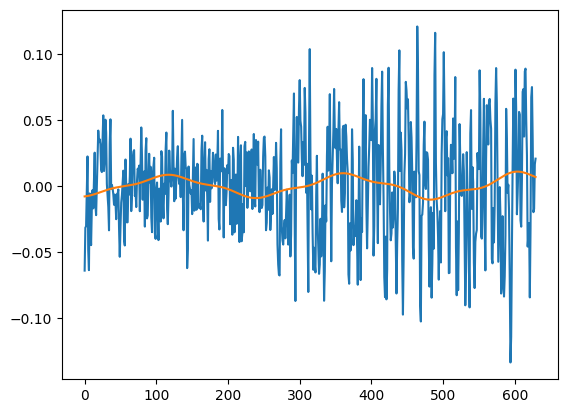

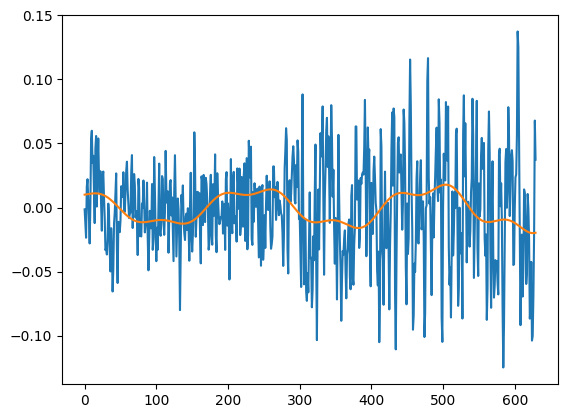

In [44]:
rec_data = np.real(dmd.reconstructed_data)
for i, dinamic in enumerate(V_r[:-1]):
    plt.plot(dinamic)
    plt.plot(rec_data[i])
    plt.show()


# Show train and test data

=== SHAPES OF TRAIN AND TEST DATA ===
|     (7, 360)    |    (7, 270)     |


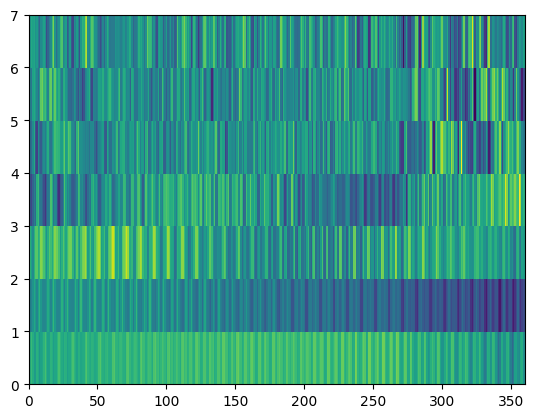

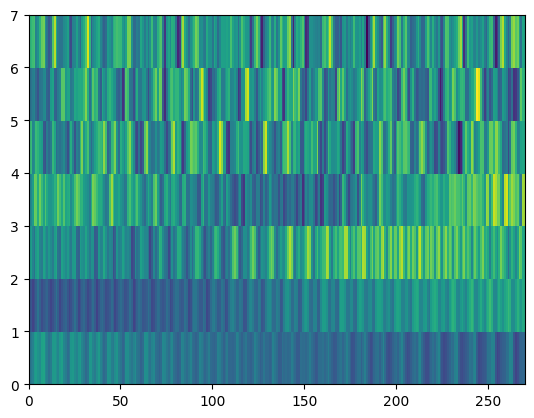

In [45]:
print("=== SHAPES OF TRAIN AND TEST DATA ===")
print("|    ", train_data.shape, "   |   ", test_data.shape, "    |")
print("=====================================")

plt.pcolor(train_data)
plt.show()
plt.pcolor(test_data)
plt.show()

# Fit DMD on train data

In [56]:
dmd = DMD(svd_rank=5, opt=False, exact=True, tlsq_rank=5)
dmd.fit(train_data[:-1])

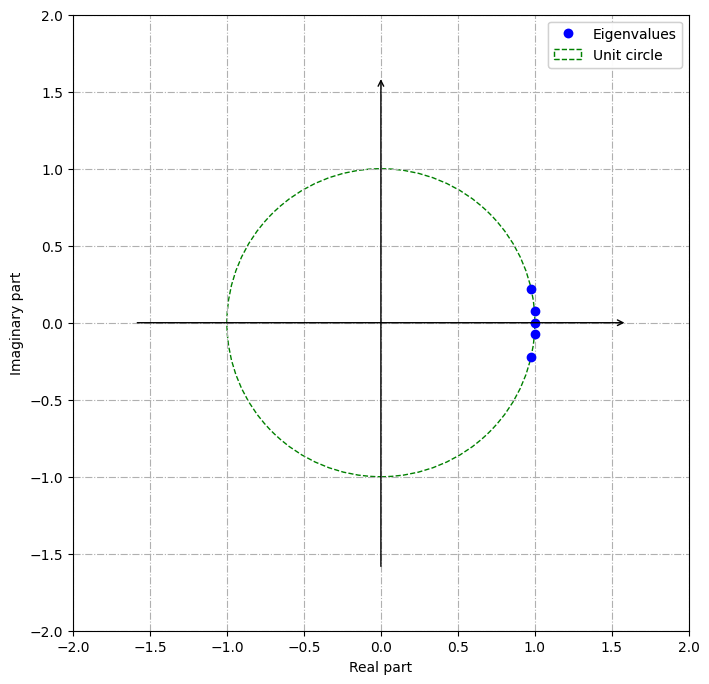

In [57]:
dmd.plot_eigs(show_axes=True, show_unit_circle=True)

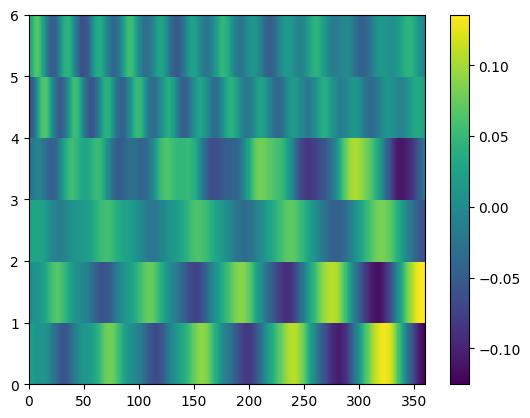

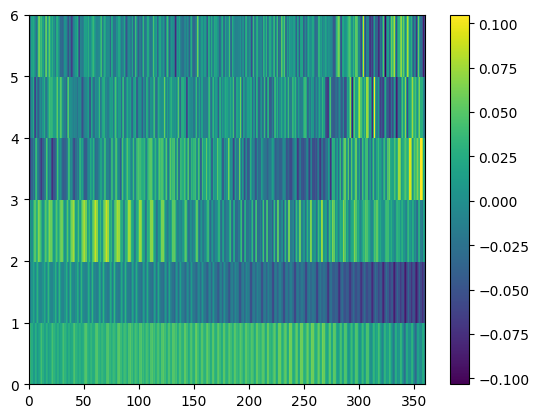

In [58]:
plt.pcolor(np.real(dmd.reconstructed_data))
plt.colorbar()
plt.show()
plt.pcolor(train_data[:-1])
plt.colorbar()

plt.show()

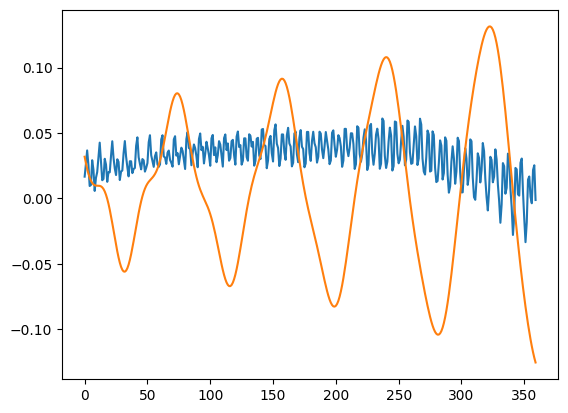

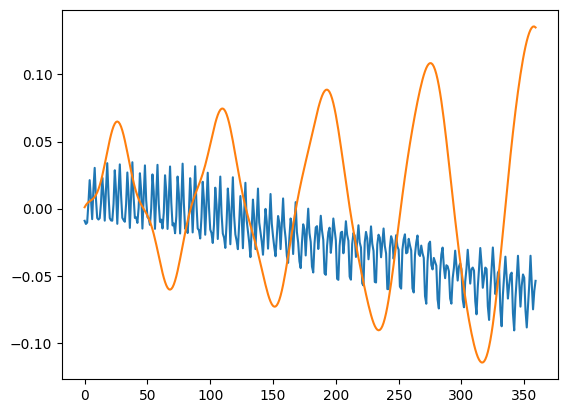

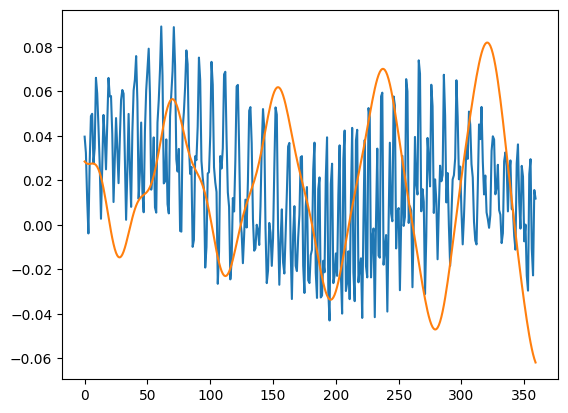

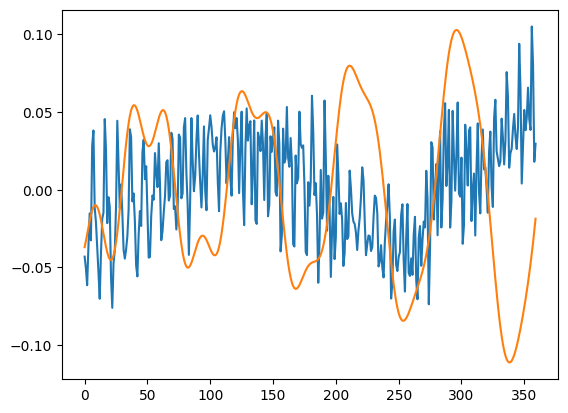

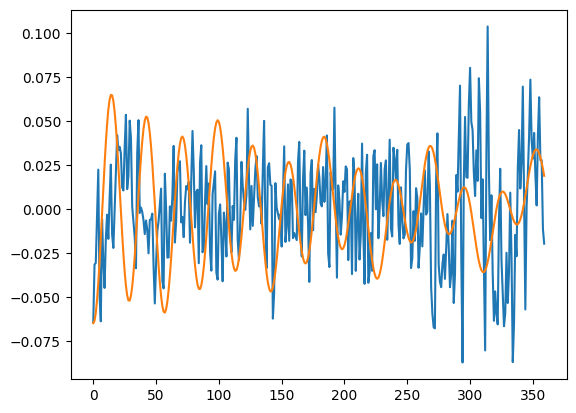

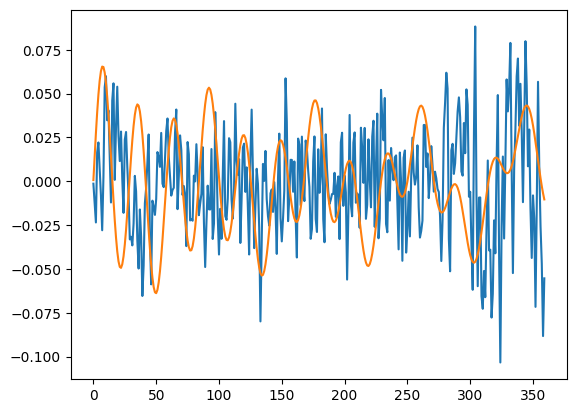

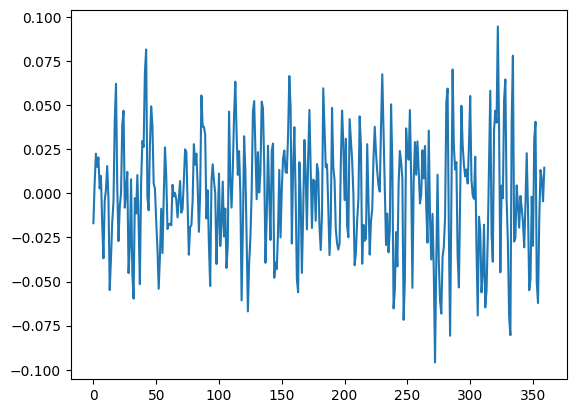

In [59]:
rec_data = np.real(dmd.reconstructed_data)
for i, dinamic in enumerate(train_data[:-1]):
    plt.plot(dinamic)
    plt.plot(rec_data[i])
    # plt.plot(train_data[-1])
    plt.show()
plt.plot(train_data[-1])
plt.show()

# PREDICT

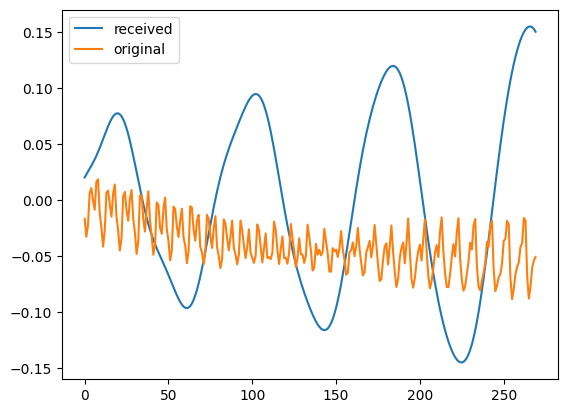

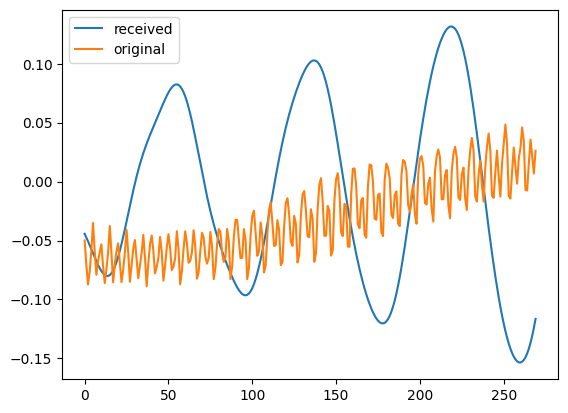

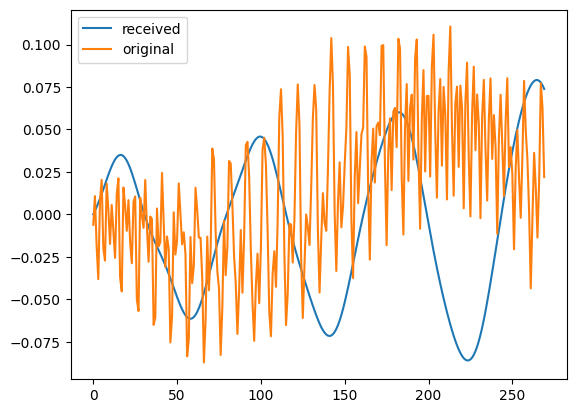

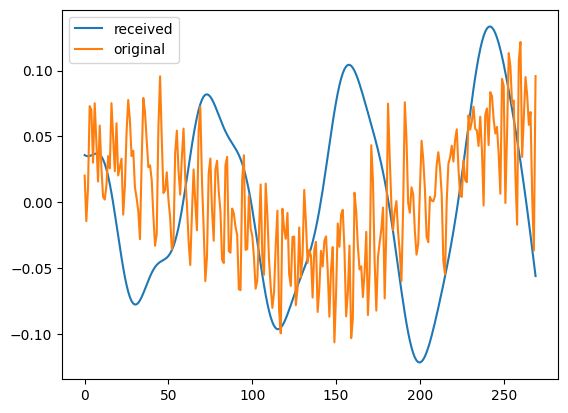

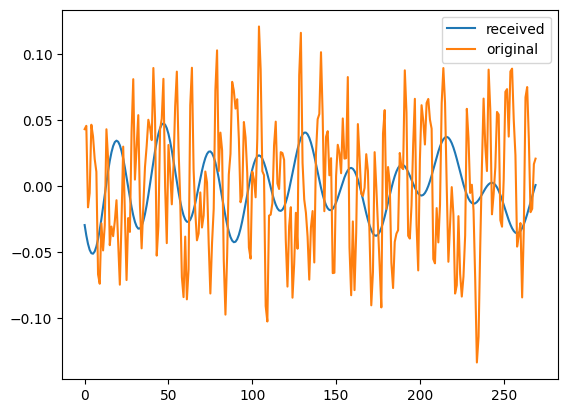

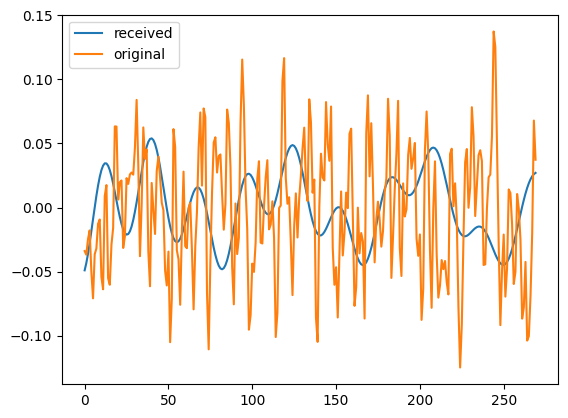

In [60]:
start_idx = len(train_data)
end_idx = start_idx + len(test_data.T)
output_data = []
res = train_data.T[-1, :-1]
# print(dmd.predict(np.arange(start_idx, end_idx)))
for i, elem in enumerate(test_data.T):
    current_idx = start_idx + i
    res = dmd.predict(res)
    res0 = np.real(res)
    output_data.append(res0)
    # print(len(output_data))

output_data = np.array(output_data)
# print(output_data.shape)
output_data = output_data.T
for i, elem in enumerate(output_data):
    plt.plot(elem, label="received")
    plt.plot(test_data[i], label="original")
    plt.legend()
    plt.show()
     

# MrDMD

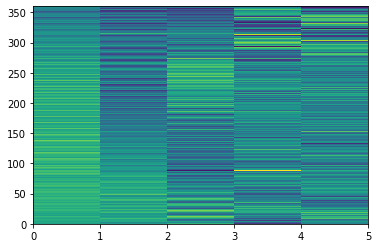

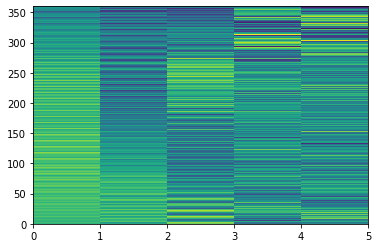

(360, 5) (360, 1)
(360, 6)


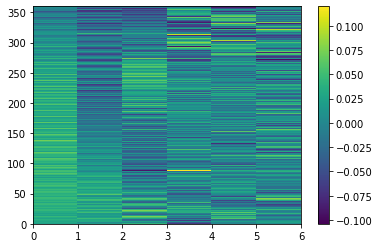

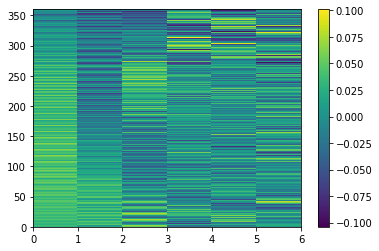

In [256]:
sub_dmd = DMD(svd_rank=-1)

dmd = MrDMD(sub_dmd, max_level=7, max_cycles=4)
dmd.fit(X=train_data[:-1])
plt.pcolor(np.real(dmd.reconstructed_data.T))
plt.show()
plt.pcolor(train_data[:-1].T)
plt.show()

print(np.real(dmd.reconstructed_data.T).shape, train_data[-1].reshape(train_data[-1].shape[0], 1).shape)
end_res = np.hstack((np.real(dmd.reconstructed_data.T), train_data[-1].reshape(train_data[-1].shape[0], 1)))
print(end_res.shape)

plt.pcolor(end_res)
plt.colorbar()
plt.show()
plt.pcolor(train_data.T)
plt.colorbar()
plt.show()

# plt.pcolor(V_r.T)

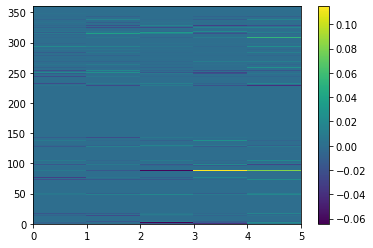

RMSE: 0.007133076611481448


In [257]:
error_pic = np.real(dmd.reconstructed_data.T) -  train_data[:-1].T

plt.pcolor(error_pic)
plt.colorbar()
plt.show()
print("RMSE:", np.sqrt(np.sum(error_pic ** 2)/error_pic.size))

In [150]:
np.real(dmd.reconstructed_data.T)[-1].shape

(5,)

In [150]:
X_test.shape

(270,)

In [258]:
test = predict(dmd, X_test, np.real(dmd.reconstructed_data.T)[-1])
test = test[:, 1:]

inx 0
inx 1
inx 3
inx 7
inx 15
inx 31
inx 63
inx 127
current (5, 1) [[ 0.02154667]
 [-0.04494338]
 [-0.0288535 ]
 [-0.03442494]
 [-0.07608493]]
inx 0
inx 1
inx 3
inx 7
inx 15
inx 31
inx 63
inx 127
current (5, 2) [[ 0.08481277]
 [ 0.03247435]
 [ 0.08867513]
 [-0.0932226 ]
 [-0.08109771]]
inx 0
inx 1
inx 3
inx 7
inx 15
inx 31
inx 63
inx 127
current (5, 3) [[ 0.15342046]
 [ 0.31270193]
 [ 0.37980371]
 [-0.24483893]
 [ 0.02409836]]
inx 0
inx 1
inx 3
inx 7
inx 15
inx 31
inx 63
inx 127
current (5, 4) [[ 0.15439807]
 [ 0.8280276 ]
 [ 0.90256209]
 [-0.44704959]
 [ 0.47378682]]
inx 0
inx 1
inx 3
inx 7
inx 15
inx 31
inx 63
inx 127
current (5, 5) [[-0.08213683]
 [ 1.53733905]
 [ 1.72023728]
 [-0.5045638 ]
 [ 1.66095656]]
inx 0
inx 1
inx 3
inx 7
inx 15
inx 31
inx 63
inx 127
current (5, 6) [[-0.95099188]
 [ 2.15913539]
 [ 2.73618984]
 [ 0.01041185]
 [ 4.08634061]]
inx 0
inx 1
inx 3
inx 7
inx 15
inx 31
inx 63
inx 127
current (5, 7) [[-3.203781  ]
 [ 1.6853084 ]
 [ 3.34709942]
 [ 1.90370397]
 [ 8.148

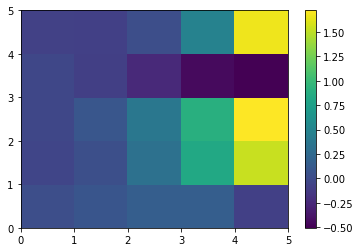

In [264]:
plt.pcolor(test[:, :5])
plt.colorbar()
plt.show()

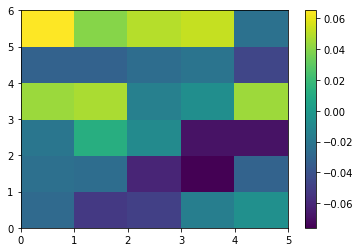

In [265]:
plt.pcolor(test_data[:, :5])
plt.colorbar()
plt.show()

In [267]:
temp = 0
for level, leaf, iter_dmd in dmd.enumerate():
    print(level, leaf, iter_dmd.atilde.shape)
         

0 0 (5, 5)
1 0 (5, 5)
1 1 (5, 5)
2 0 (5, 5)
2 1 (5, 5)
2 2 (5, 5)
2 3 (5, 5)
3 0 (5, 5)
3 1 (5, 5)
3 2 (5, 5)
3 3 (5, 5)
3 4 (5, 5)
3 5 (5, 5)
3 6 (5, 5)
3 7 (5, 5)
4 0 (5, 5)
4 1 (5, 5)
4 2 (5, 5)
4 3 (5, 5)
4 4 (5, 5)
4 5 (5, 5)
4 6 (5, 5)
4 7 (5, 5)
4 8 (5, 5)
4 9 (5, 5)
4 10 (5, 5)
4 11 (5, 5)
4 12 (5, 5)
4 13 (5, 5)
4 14 (5, 5)
4 15 (5, 5)
5 0 (5, 5)
5 1 (5, 5)
5 2 (5, 5)
5 3 (5, 5)
5 4 (5, 5)
5 5 (5, 5)
5 6 (5, 5)
5 7 (5, 5)
5 8 (5, 5)
5 9 (5, 5)
5 10 (5, 5)
5 11 (5, 5)
5 12 (5, 5)
5 13 (5, 5)
5 14 (5, 5)
5 15 (5, 5)
5 16 (5, 5)
5 17 (5, 5)
5 18 (5, 5)
5 19 (5, 5)
5 20 (5, 5)
5 21 (5, 5)
5 22 (5, 5)
5 23 (5, 5)
5 24 (5, 5)
5 25 (5, 5)
5 26 (5, 5)
5 27 (5, 5)
5 28 (5, 5)
5 29 (5, 5)
5 30 (5, 5)
5 31 (5, 5)
6 0 (5, 5)
6 1 (5, 5)
6 2 (5, 5)
6 3 (5, 5)
6 4 (5, 5)
6 5 (5, 5)
6 6 (5, 5)
6 7 (5, 5)
6 8 (5, 5)
6 9 (5, 5)
6 10 (5, 5)
6 11 (5, 5)
6 12 (5, 5)
6 13 (5, 5)
6 14 (5, 5)
6 15 (5, 5)
6 16 (5, 5)
6 17 (5, 5)
6 18 (5, 5)
6 19 (5, 5)
6 20 (5, 5)
6 21 (5, 5)
6 22 (5, 5)
6 23 (5, 5)
6

In [117]:
def predict_one(mrdmd, X):
    # return np.sum(np.array([np.hstack([mrdmd.dmd_tree[level, leaf].predict(X) for leaf in mrdmd.dmd_tree.index_leaves(level)]) for level in mrdmd.dmd_tree.levels]), axis=0)
    some_stacks = []
    stack = []
    flag = False
    for level in mrdmd.dmd_tree.levels:
        # stack = []
        inx = list(mrdmd.dmd_tree.index_leaves(level))[-1]
        print("inx", inx)
        if mrdmd.dmd_tree[level, inx].modes.shape[-1] == 0:
            flag = True
            continue
        # print(X, X.shape)
        pred_data = mrdmd.dmd_tree[level, inx].predict(X.reshape(X.shape[0], 1))
        # print(level, leaf, pred_data, pred_data.shape)
        # print("check stack", np.array(stack).shape)
        if len(stack) == 0:
            stack = np.real(pred_data)
        else:
            stack += np.real(pred_data)
        # stack.append(pred_data)

        # if len(stack) == 0:
        #     stack = np.real(pred_data)
        # else:
        #     stack += np.real(pred_data)
        
        # print("check stack", np.array(stack).shape)
        # leaf_stack = np.vstack(stack)
        # some_stacks.append(leaf_stack)
    # print("shape", np.array(stack).shape)
    return stack
    # return np.sum(np.array(some_stacks), axis=0)

In [113]:
def predict(mrdmd, X, last_value):
    current_val = last_value.reshape(last_value.shape[0], 1)
    for _ in range(len(X)):
        last_value = predict_one(mrdmd, last_value)
        print("current", current_val.shape, last_value)
        current_val = np.hstack((current_val, last_value))
    return current_val

In [54]:
dmd.eigs.shape

(371,)

In [52]:
operators = [partial_dmd.atilde for partial_dmd in dmd]

In [53]:
len(operators)

255

In [23]:
for iter_mode in dmd.modes:
    print(iter_mode)

[-7.26754598e-01+0.j         -7.37239622e-01+0.j
 -9.15067886e-01+0.j         -7.73548856e-01+0.j
  7.81527929e-01+0.j          6.93582696e-01+0.j
  5.44717379e-01+0.j         -5.46589456e-01+0.j
  7.59518751e-01+0.j          9.03732073e-01+0.j
 -8.81463276e-01+0.j         -6.78369490e-01+0.j
 -6.59648390e-01+0.j          5.35205654e-01+0.j
 -6.03926381e-01+0.j          8.06984426e-01+0.j
  3.42424354e-01+0.32862857j  3.42424354e-01-0.32862857j
  6.87014702e-01+0.j         -4.37021722e-01+0.j
 -3.08502045e-01+0.j         -3.79613854e-01+0.j
 -2.50089606e-01+0.j          6.37074091e-01+0.j
  7.24758513e-01+0.j          9.19079858e-01+0.j
 -8.96945292e-01+0.j          9.08306271e-01+0.j
  8.92129797e-01+0.j         -8.56678064e-01+0.j
  7.76996958e-01+0.j         -6.69715598e-01+0.j
 -5.77264709e-01+0.j          5.14778741e-01+0.j
  5.36618188e-01+0.j         -5.93763244e-01+0.j
  3.31170482e-01+0.j         -7.85686565e-01+0.j
  6.40318287e-01+0.j         -1.88657975e-01+0.j
 -7.33787480

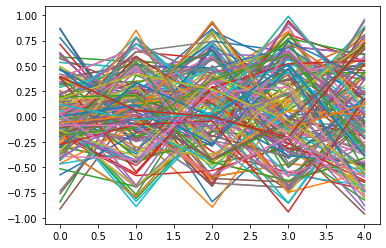

In [24]:
pmodes = dmd.partial_modes(level=7)
fig = plt.plot(pmodes.real)

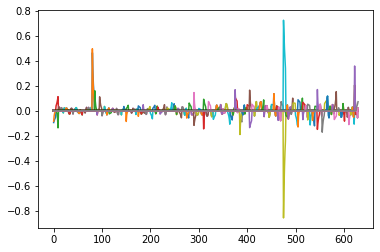

In [25]:
pdyna = dmd.partial_dynamics(level=7)
fig = plt.plot(pdyna.real.T)

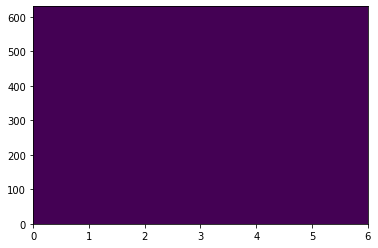

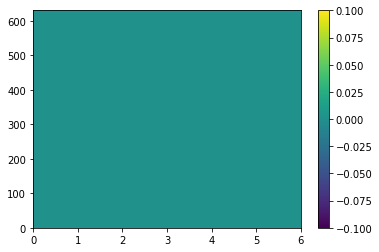

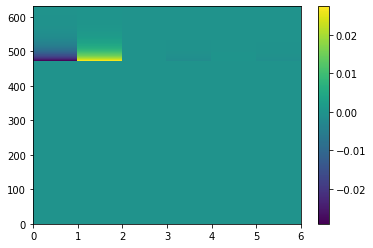

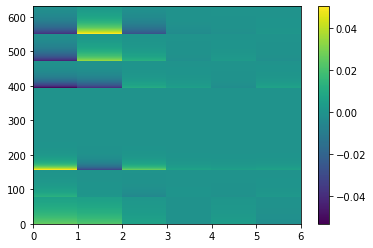

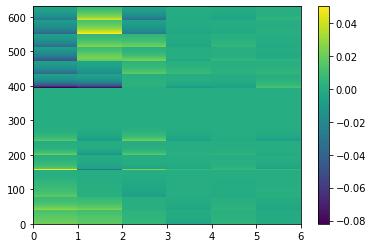

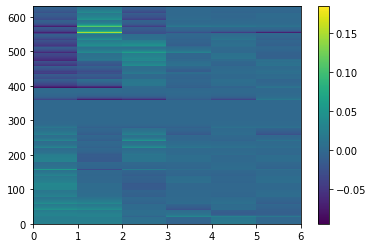

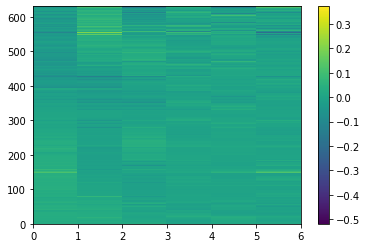

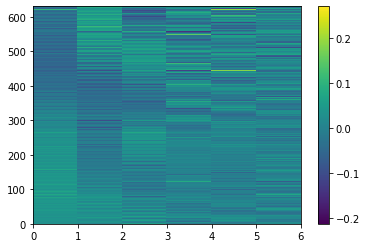

In [32]:
pdata = dmd.partial_reconstructed_data(level=0)
plt.pcolor(np.real(pdata).T)
plt.show()
for i in range(1, 8):
    pdata += dmd.partial_reconstructed_data(level=i)
    plt.pcolor(np.real(pdata).T)
    plt.colorbar()
    plt.show()

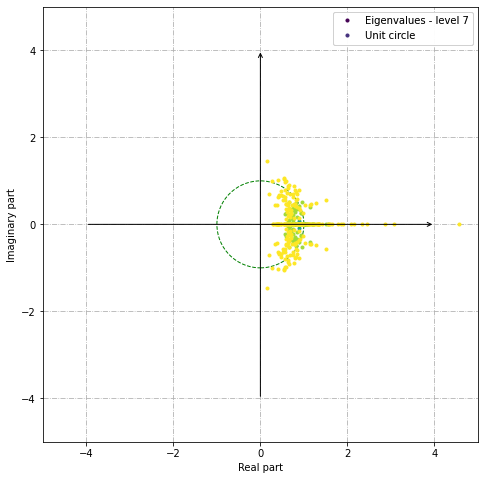

In [290]:
dmd.plot_eigs(show_axes=True, show_unit_circle=True, figsize=(8, 8))

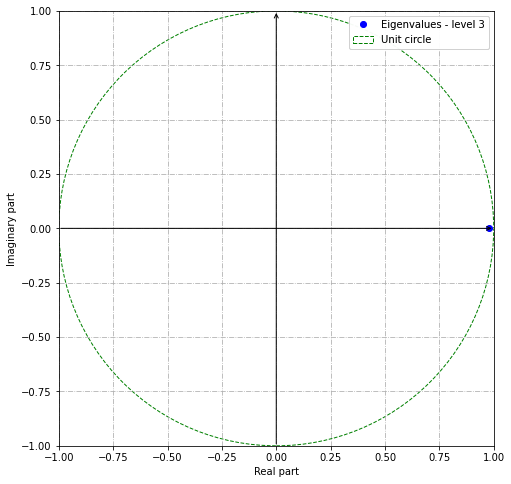

In [370]:
dmd.plot_eigs(show_axes=True, show_unit_circle=True, figsize=(8, 8), level=3, node=0)